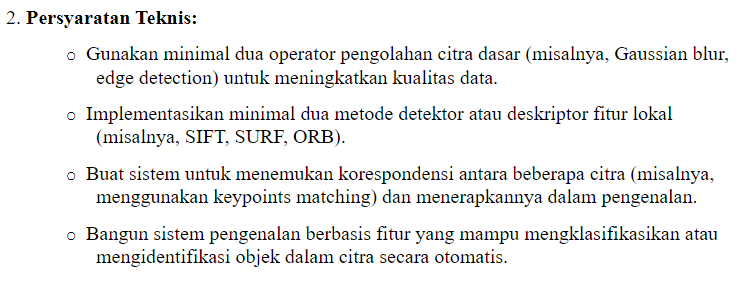

In [2]:
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
import pytesseract

In [3]:
def bgr2rgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

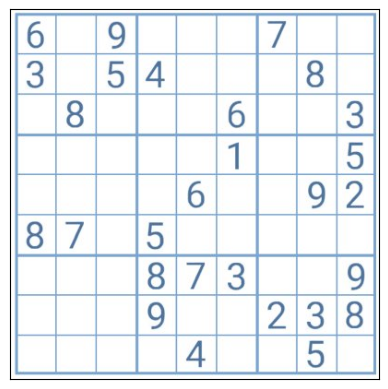

In [4]:
FILE_PATH = './dummy_input/sudoku grid 2.jpg'
# FILE_PATH = './dummy_input/sudoku_grid_ex3.jpg'
# FILE_PATH = './dummy_input/wacky grid 3.png'
# FILE_PATH = './dummy_input/wacky grid 2.jpg'
# FILE_PATH = './dummy_input/wacky grid 1.jpg'
image = cv2.imread(FILE_PATH)
# image = cv2.resize(image, (1000, 1000))
plt.imshow(bgr2rgb(image))
plt.xticks([])
plt.yticks([])
plt.show() 

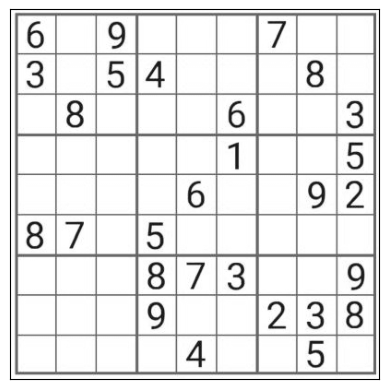

In [5]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show() 

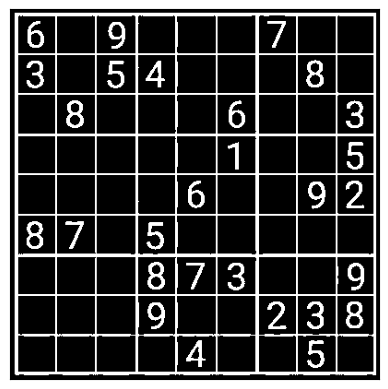

In [6]:
blur_gray_image = cv2.GaussianBlur(gray_image, (5, 5), 1)
thresh_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 7)
plt.imshow(thresh_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show() 

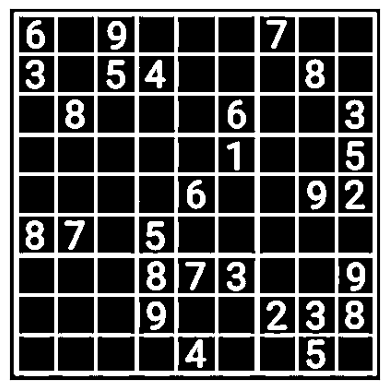

In [7]:
# Define a custom kernel, same size but less intense (e.g., fewer 1s)
kernel = np.array([[0, 1, 0],
                   [1, 1, 1],
                   [0, 1, 0]], dtype=np.uint8)

# Apply dilation with fewer iterations (e.g., iteration=1)
dilated_image = cv2.dilate(thresh_image, kernel, iterations=1)

# Display the dilated image
plt.imshow(dilated_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

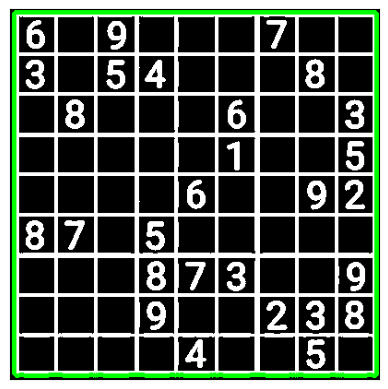

In [8]:
contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
# Step 2: Find the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# Step 3: Draw the largest contour on a copy of the dilated image
contour_image = cv2.cvtColor(dilated_image, cv2.COLOR_GRAY2BGR)  # Convert to BGR for color display
cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 3)  # Draw in green

# Print the largest contour points
# print("Largest Contour Points:")
# print(largest_contour)

# Display the contour image
plt.imshow(contour_image)
plt.xticks([])
plt.yticks([])
plt.show()

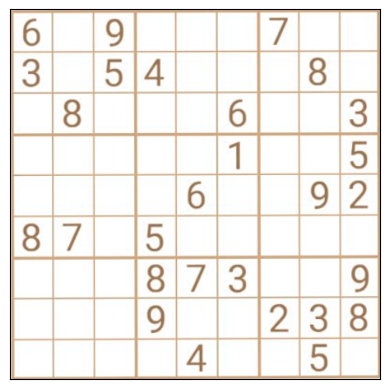

In [9]:
# Step 3: Get the bounding rectangle and points
epsilon = 0.02 * cv2.arcLength(largest_contour, True)
approx = cv2.approxPolyDP(largest_contour, epsilon, True)

pts = approx.reshape(4, 2)

# Step 4: Order points (top-left, top-right, bottom-right, bottom-left)
# Sort points to get the correct order
rect = np.zeros((4, 2), dtype="float32")
s = pts.sum(axis=1)
rect[0] = pts[np.argmin(s)]  # Top-left
rect[2] = pts[np.argmax(s)]  # Bottom-right
diff = np.diff(pts, axis=1)
rect[1] = pts[np.argmin(diff)]  # Top-right
rect[3] = pts[np.argmax(diff)]  # Bottom-left

# Step 5: Fix the perspective
width = 450  # Desired width of the output
height = 450  # Desired height of the output
dst = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype="float32")

# Perform the perspective transform
M = cv2.getPerspectiveTransform(rect, dst)
warped_image = cv2.warpPerspective(image, M, (width, height))

plt.imshow(warped_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

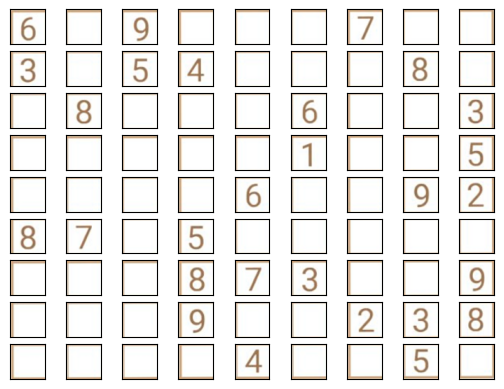

In [10]:
def splitBoxes(img):
    rows = np.vsplit(img,9)
    boxes=[]
    for r in rows:
        cols= np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

boxes = splitBoxes(warped_image)

for i in range(len(boxes)):
    plt.subplot(9, 9, i + 1)
    plt.imshow(boxes[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

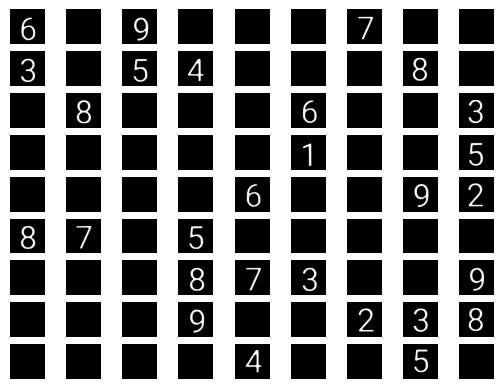

In [11]:
# Define parameters for filtering
MIN_SIZE = 20    # Minimum size of a component to consider it valid (adjust as needed)
MAX_SIZE = 40000   # Maximum size to filter out noise (adjust as needed)
EDGE_THRESHOLD = 2  # Minimum distance from edges to consider a component (adjust as needed)

# Prepare a list to hold the processed images
processed_boxes = []

for i in range(len(boxes)):
    target_image = boxes[i]

    # Convert the image to grayscale
    gray_target = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)
    gray_target = cv2.resize(gray_target, (500, 500))

    # Step 1: Threshold the image to create a binary image
    _, binary_image = cv2.threshold(gray_target, 150, 255, cv2.THRESH_BINARY_INV)

    # Step 2: Find connected components
    num_labels, labels_im = cv2.connectedComponents(binary_image)

    # Step 3: Initialize variables to find the best component
    best_component = None  # Initialize as None
    best_size = 0
    height, width = gray_target.shape
    center_y, center_x = height // 2, width // 2  # Calculate the center of the image

    # Step 4: Loop through each component
    for label in range(1, num_labels):  # Start from 1 to skip the background
        component_mask = (labels_im == label).astype(np.uint8)  # Create a mask for the component
        size = np.sum(component_mask)  # Count the number of pixels in the component

        # Calculate the bounding box of the component
        y_indices, x_indices = np.where(component_mask > 0)
        if len(y_indices) == 0 or len(x_indices) == 0:
            continue  # Skip if there are no pixels in the component

        # Get the bounding box coordinates
        min_y, max_y = np.min(y_indices), np.max(y_indices)
        min_x, max_x = np.min(x_indices), np.max(x_indices)

        # Check if the component meets size and edge proximity criteria
        if (MIN_SIZE <= size <= MAX_SIZE and
            min_y > EDGE_THRESHOLD and max_y < height - EDGE_THRESHOLD and
            min_x > EDGE_THRESHOLD and max_x < width - EDGE_THRESHOLD):
            
            # Check if this is the best component found based on size
            if size > best_size:
                best_size = size
                best_component = component_mask  # Assign the mask to best_component

    # Step 5: Create a mask for the best component
    if best_component is not None:  # Check if a component was found
        mask = best_component.astype(np.uint8) * 255  # Convert to uint8 for masking

        # Step 6: Use the mask to create an output image where the digit is white and the background is black
        output_image = np.zeros_like(gray_target)  # Create a black image
        output_image[mask > 0] = 255  # Set the pixels of the digit to white

        processed_boxes.append(output_image)  # Store the processed image
    else:
        # If no component was found, append a completely black image
        processed_boxes.append(np.zeros_like(gray_target))  # All black image for no digit box

# Display the processed images
for i in range(len(processed_boxes)):
    plt.subplot(9, 9, i + 1)
    plt.imshow(processed_boxes[i], cmap='gray')  # Display processed images
    plt.axis('off')

plt.show()


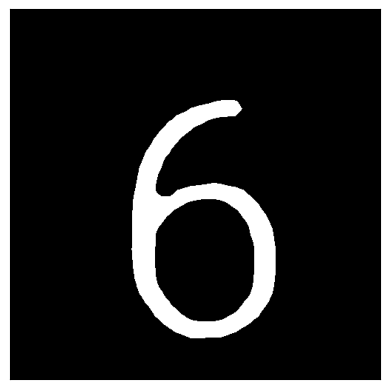

(500, 500)


In [12]:
target_image = processed_boxes[0]

plt.imshow(target_image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

print(target_image.shape)


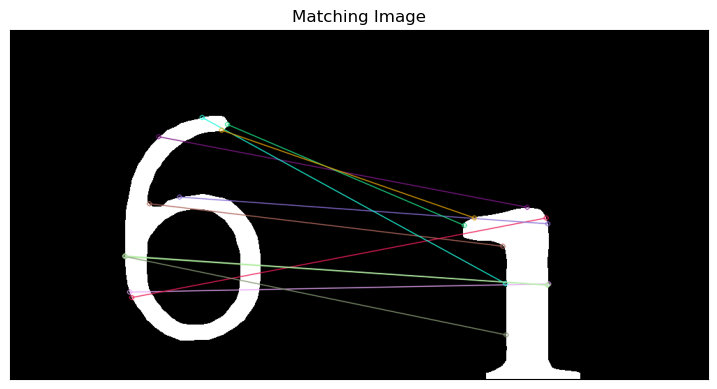

In [13]:
# Initialize SIFT or ORB with a higher feature count (you can switch to AKAZE if needed)
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_L2)

# Detect keypoints and descriptors in the target image
target_keypoint, target_descriptor = orb.detectAndCompute(target_image, None)

# List to store processed images
data = []

# Load images from file path
FILE_PATH = './Printed Match Data/'
for sub in os.listdir(FILE_PATH):
    sub_path = os.path.join(FILE_PATH, sub)
    for image_path in os.listdir(sub_path):
        path = os.path.join(sub_path, image_path)
        image_data = cv2.imread(path)
        image_data = cv2.resize(image_data, (500, 500))
        image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY) 
        _, binary_image = cv2.threshold(image_data, 100, 255, cv2.THRESH_BINARY)
        data.append(binary_image)

# Initialize best match tracking variables
best_match_score = 0
best_match_data = {}

# Process each image in data
for index, img in enumerate(data):
    # Detect keypoints and descriptors in each image
    img_keypoint, img_descriptor = orb.detectAndCompute(img, None)
    
    # Skip if no descriptors were found
    if img_descriptor is None:
        continue
    
    # Use knnMatch to get two best matches for each descriptor
    matches = bf.knnMatch(target_descriptor, img_descriptor, k=2)
    
    # Apply a ratio test for higher precision and filter matches by distance
    good_matches = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:
            good_matches.append(m)
    
    # Calculate a match score by combining match count and quality
    current_match_score = sum([1.0 / (match.distance + 1e-10) for match in good_matches])
    
    # Update best match if current score is higher
    if current_match_score > best_match_score:
        best_match_score = current_match_score
        best_match_data = {
            'image_data': img,
            'keypoint': img_keypoint,
            'match': good_matches
        }

# Draw matches between target and best match
result = cv2.drawMatches(
    target_image,
    target_keypoint,
    best_match_data['image_data'],
    best_match_data['keypoint'],
    best_match_data['match'],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Display final output
plt.figure(figsize=(9, 8))
plt.imshow(result)
plt.title('Matching Image')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
dwada

In [ ]:
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_L2)

FILE_PATH = './Printed Match Data/'
data = []
labels = []

for sub in os.listdir(FILE_PATH):
    sub_path = os.path.join(FILE_PATH, sub)
    for image_path in os.listdir(sub_path):
        path = os.path.join(sub_path, image_path)
        image_data = cv2.imread(path)
        image_data = cv2.resize(image_data, (300, 300))
        image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY) 
        _, binary_image = cv2.threshold(image_data, 100, 255, cv2.THRESH_BINARY)
        data.append(binary_image)
        labels.append(sub)  # Store the folder name as the label

# Function to check if an image is blank (all black)
def is_blank(image, threshold=10):
    return np.mean(image) < threshold

# Initialize a 9x9 matrix with zeros to store the results
results_matrix = np.zeros((9, 9), dtype=int)

# Process each image in processed_boxes and populate the results matrix
for idx, target_image in enumerate(processed_boxes):
    row, col = divmod(idx, 9)  # Calculate row and col for 9x9 placement
    
    # Check if target image is blank
    if is_blank(target_image):
        results_matrix[row, col] = 0
        continue

    # Detect keypoints and descriptors in the target image
    target_keypoint, target_descriptor = orb.detectAndCompute(target_image, None)
    
    # Initialize tracking for the best match score and corresponding label
    best_match_score = 0
    best_label = None

    # Loop through the stored data images for matching
    for index, img in enumerate(data):
        img_keypoint, img_descriptor = orb.detectAndCompute(img, None)
    
        # Skip if no descriptors were found
        if img_descriptor is None:
            continue
    
        # Use knnMatch to get two best matches for each descriptor
        matches = bf.knnMatch(target_descriptor, img_descriptor, k=2)
    
        # Apply a ratio test for higher precision and filter matches by distance
        good_matches = []
        for m, n in matches:
            if m.distance < 0.6 * n.distance:
                good_matches.append(m)
    
        # Calculate a match score by combining match count and quality
        current_match_score = sum([1.0 / (match.distance + 1e-10) for match in good_matches])

        # Check if the current image is the best match
        if current_match_score > best_match_score:
            best_match_score = current_match_score
            best_label = labels[index]

    # Assign the best label to the results matrix, or 0 if no match is found
    results_matrix[row, col] = int(best_label) if best_label is not None else 0

print("Results Matrix:")
print(results_matrix)


Results Matrix:
[[2 0 5 0 0 0 7 0 0]
 [7 0 6 4 0 0 0 3 0]
 [0 2 0 0 0 7 0 0 3]
 [0 0 0 0 0 1 0 0 2]
 [0 0 0 0 6 0 0 3 4]
 [8 7 0 5 0 0 0 0 0]
 [0 0 0 5 7 1 0 0 2]
 [0 0 0 8 0 0 4 2 1]
 [0 0 0 0 1 0 0 5 0]]


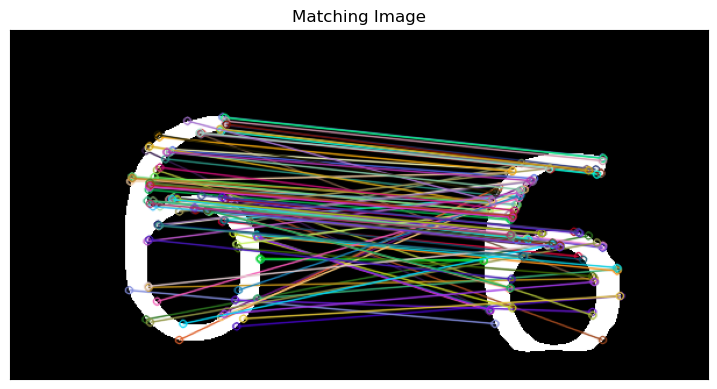

In [ ]:
# # Initialize ORB
# orb = cv2.ORB_create()

# # Detect keypoints and descriptors in the target image
# target_keypoint, target_descriptor = orb.detectAndCompute(target_image, None)

# # List to store processed images
# data = []
# dwadawdwdada
# # Load images from file path
# FILE_PATH = './Printed Match Data/'
# for sub in os.listdir(FILE_PATH):
#     sub_path = os.path.join(FILE_PATH, sub)
#     for image_path in os.listdir(sub_path):
#         path = os.path.join(sub_path, image_path)
#         image_data = cv2.imread(path)
#         image_data = cv2.resize(image_data, (300, 300))
#         image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY) 
#         _, binary_image = cv2.threshold(image_data, 100, 255, cv2.THRESH_BINARY)
#         data.append(binary_image)

# # Display processed images
# # plt.figure(figsize=(6, 7))
# # for i in range(10):
# #     plt.subplot(2, 5, i + 1)
# #     plt.imshow(data[i], cmap='gray')
# #     plt.xlabel(f'{data[i].shape}')
# #     plt.xticks([])
# #     plt.yticks([])
# # plt.show()

# # Initialize best match tracking variables
# best_matches = 0
# best_match_data = {}

# # BFMatcher with NORM_HAMMING for binary descriptors
# bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# # Process each image in data
# for index, img in enumerate(data):
#     # Detect keypoints and descriptors in each image
#     img_keypoint, img_descriptor = orb.detectAndCompute(img, None)
    
#     # Skip if no descriptors were found
#     if img_descriptor is None:
#         continue
    
#     # Match descriptors between target and current image
#     matches = bf.match(target_descriptor, img_descriptor)
    
#     # Sort matches by distance (lower is better)
#     matches = sorted(matches, key=lambda x: x.distance)
#     current_matches = len(matches)

#     # Update best match if current image has more matches
#     if current_matches > best_matches:
#         best_matches = current_matches
#         best_match_data = {
#             'image_data': img,
#             'keypoint': img_keypoint,
#             'match': matches
#         }

# # Draw matches between target and best match
# result = cv2.drawMatches(
#     target_image,
#     target_keypoint,
#     best_match_data['image_data'],
#     best_match_data['keypoint'],
#     best_match_data['match'],
#     None,
#     flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
# )

# # Display final output
# plt.figure(figsize=(9, 8))
# plt.imshow(result)
# plt.title('Matching Image')
# plt.xticks([])
# plt.yticks([])
# plt.show()


Sudoku Solved:
Answer Matrix:
[[1 9 2 3 4 5 6 7 8]
 [3 4 6 2 7 8 1 5 9]
 [5 7 8 1 9 6 3 2 4]
 [2 1 7 4 6 3 8 9 5]
 [9 6 3 8 5 2 7 4 1]
 [8 5 4 7 1 9 2 3 6]
 [7 8 1 9 2 4 5 6 3]
 [4 2 5 6 3 1 9 8 7]
 [6 3 9 5 8 7 4 1 2]]


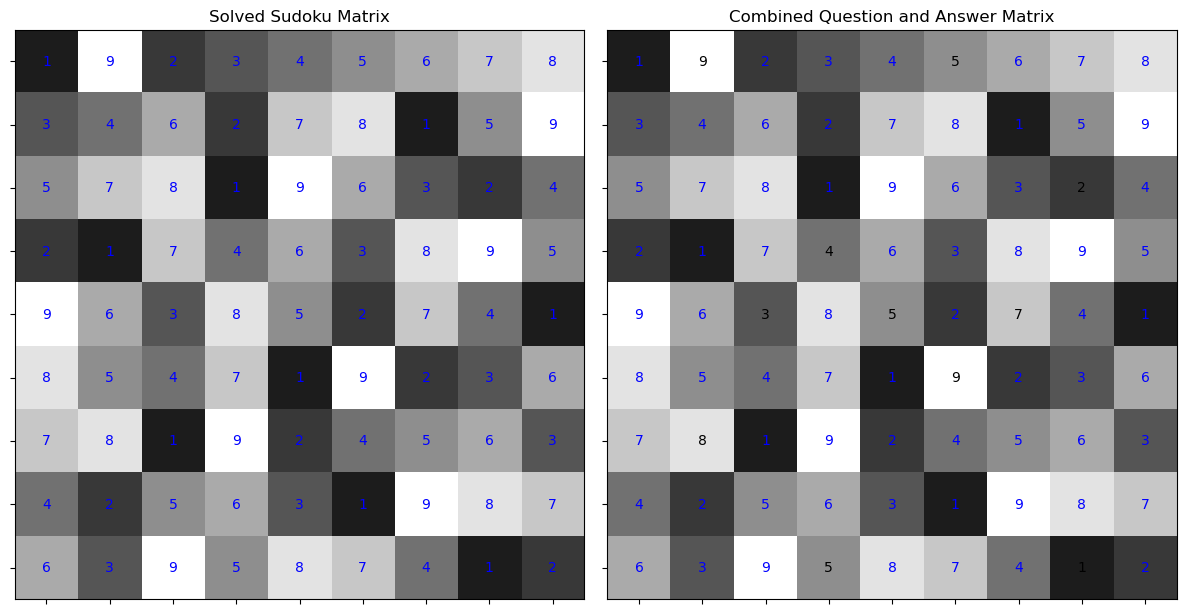

In [ ]:
# Define a function to check if a number can be placed in the Sudoku grid
def is_valid_move(matrix, row, col, num):
    # Check row
    if num in matrix[row]:
        return False
    # Check column
    if num in matrix[:, col]:
        return False
    # Check 3x3 grid
    start_row, start_col = 3 * (row // 3), 3 * (col // 3)
    if num in matrix[start_row:start_row + 3, start_col:start_col + 3]:
        return False
    return True

# Backtracking function to solve the Sudoku puzzle
def solve_sudoku(matrix):
    for row in range(9):
        for col in range(9):
            if matrix[row, col] == 0:  # Empty cell found
                for num in range(1, 10):  # Numbers 1 to 9
                    if is_valid_move(matrix, row, col, num):
                        matrix[row, col] = num  # Place the number
                        if solve_sudoku(matrix):  # Recursive call
                            return True
                        matrix[row, col] = 0  # Backtrack
                return False  # No valid number found, backtrack
    return True  # Puzzle solved


# Copy the original matrix for displaying later
original_matrix = sudoku_matrix.copy()

# Solve the Sudoku
if solve_sudoku(sudoku_matrix):
    print("Sudoku Solved:")
else:
    print("No solution exists")

# Display the answer matrix
print("Answer Matrix:")
print(sudoku_matrix)

# Combine the question and answer matrices for display
combined_matrix = np.where(original_matrix != 0, original_matrix, sudoku_matrix)

# Display the answer and combined matrix
plt.figure(figsize=(12, 6))

# Display answer matrix
plt.subplot(1, 2, 1)
plt.title('Solved Sudoku Matrix')
plt.imshow(sudoku_matrix, cmap='gray', vmin=0, vmax=9)
plt.xticks(np.arange(9), [])
plt.yticks(np.arange(9), [])
for (i, j), val in np.ndenumerate(sudoku_matrix):
    plt.text(j, i, f'{val}', ha='center', va='center', color='blue' if val != 0 else 'black')

# Display combined matrix
plt.subplot(1, 2, 2)
plt.title('Combined Question and Answer Matrix')
plt.imshow(combined_matrix, cmap='gray', vmin=0, vmax=9)
plt.xticks(np.arange(9), [])
plt.yticks(np.arange(9), [])
for (i, j), val in np.ndenumerate(combined_matrix):
    plt.text(j, i, f'{val}', ha='center', va='center', color='blue' if original_matrix[i, j] == 0 else 'black')

plt.tight_layout()
plt.show()
